In [1]:
!#pip install xgboost

In [64]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [3]:
import warnings

warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

In [4]:
df = pd.read_csv('games_may2024_full.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87806 entries, 0 to 87805
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   AppID                     87806 non-null  int64  
 1   name                      87803 non-null  object 
 2   release_date              87806 non-null  object 
 3   required_age              87806 non-null  int64  
 4   price                     87806 non-null  float64
 5   dlc_count                 87806 non-null  int64  
 6   detailed_description      83656 non-null  object 
 7   about_the_game            83634 non-null  object 
 8   short_description         83713 non-null  object 
 9   reviews                   10314 non-null  object 
 10  header_image              87806 non-null  object 
 11  website                   39906 non-null  object 
 12  support_url               42224 non-null  object 
 13  support_email             73123 non-null  object 
 14  window

Due to processing the data on my laptop (normally use a desktop with decent hardware), we will use more memory efficient methods. We will use One-Hot-Encoding to process the categorical data that's in lists. We will also micromange datatypes to be as small as feasible where we can (e.g. "int8").

Clean the data to fix the formatting.

In [6]:
list_columns = ['tags', 'genres', 'categories', 'developers', 'publishers']

for col in list_columns:
    df[col] = df[col].astype(str).fillna('')
    
    df[col] = df[col].str.replace('[', '', regex=False).str.replace(']', '', regex=False)
    df[col] = df[col].str.replace("'", "", regex=False).str.replace('"', '', regex=False)
    
    df[col] = df[col].str.replace(', ', ',', regex=False)
    
    df[col] = df[col].str.strip()

In [7]:
df_genres_dummies = df['genres'].str.get_dummies(sep=',')

In [8]:
df = pd.concat([df, df_genres_dummies], axis=1)
df = df.drop('genres', axis=1)

In [9]:
df_cat_dummies = df['categories'].str.get_dummies(sep=',')

In [10]:
df_cat_dummies = df_cat_dummies.astype(pd.SparseDtype("int8", 0))
df = pd.concat([df, df_cat_dummies], axis=1)
df = df.drop('categories', axis=1)

For features with high cardinality (like tags), we will limit it to the top 200.

In [11]:
tag_series = df['tags'].str.split(',', expand=True).stack()
top_tags = tag_series.value_counts().nlargest(200).index.tolist()

In [12]:
for tag in top_tags:
    new_col_name = f'tag_{tag}'
    df[new_col_name] = df['tags'].str.contains(tag, regex=False, na=False).astype('int8')

In [13]:
sparse_tag_cols = [f'tag_{tag}' for tag in top_tags]
df[sparse_tag_cols] = df[sparse_tag_cols].astype(pd.SparseDtype("int8", 0))
df = df.drop('tags', axis=1)

We will encode developers and publishers the same way. It is likely that a company outside the top 200 would be unlikely to have an impact on a game's performance.

In [14]:
for col_name in ['developers', 'publishers']:
    studio_series = df[col_name].str.split(',', expand=True).stack()
    top_studios = studio_series.value_counts().nlargest(200).index.tolist()
    
    for studio in top_studios:
        new_col_name = f'{col_name}_is_{studio}'
        df[new_col_name] = df[col_name].str.contains(studio, regex=False, na=False).astype('int8')

    sparse_studio_cols = [f'{col_name}_is_{studio}' for studio in top_studios]
    df[sparse_studio_cols] = df[sparse_studio_cols].astype(pd.SparseDtype("int8", 0))

    df = df.drop(col_name, axis=1)

Next, we will eliminate attributes we do not want to consider. Including other review and popularity factors could muddy the water for the data analysis as these likely correlate together. Recent reviews is also contingent on the data's capture time. Languages could have a very minor impact, but it is also likely to be impacted more on budget of the game and perhaps popularity after the fact. Other identifiers like AppID and even name are not necessary either for finding the most impactful influences on positive recommendations.

In [15]:
columns_to_drop = [
    'estimated_owners',
    'supported_languages',
    'full_audio_languages',
    'AppID',
    'name',
    'detailed_description',
    'about_the_game',
    'short_description',
    'reviews',
    'header_image',
    'website',
    'support_url',
    'support_email',
    'metacritic_url',
    'notes',
    'packages',
    'screenshots',
    'movies',
    'user_score',
    'score_rank',
    'pct_pos_recent',
    'recommendations',
    'negative',
    'num_reviews_recent',
]

df = df.drop(columns_to_drop, axis=1, errors='ignore')

We will prepare the release date data to be more useful. A MM-DD-YYYY DTG is not very useful for analysis, however the month and year on their own might be. We will separate those and ignore the day.

In [16]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

df['release_month'] = df['release_date'].dt.month.fillna(0).astype('int8')

df['release_year'] = df['release_date'].dt.year.fillna(0).astype('int32')

df = df.drop('release_date', axis=1)

Set our X and y.

In [17]:
y = df['positive']
X = df.drop(['positive'], axis=1)

Next, we will scale numerical data.

In [18]:
numerical_cols = X.select_dtypes(include=[np.float64, np.int64, np.int32]).columns.tolist()

cols_to_exclude = [col for col in numerical_cols if 'month' in col or 'year' in col]
cols_to_scale = [col for col in numerical_cols if col not in cols_to_exclude]

scaler = StandardScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

In [19]:
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_scaled, test_size=0.2, random_state=42
)

We will use XGPBoost as a regression model for the data. XGP is more efficient with sparse data (which we have).

In [20]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    n_jobs=-1,  # set to use all cpus
    random_state=42,
    tree_method='hist'
)

xgb_model.fit(X_train.values, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)

We will extract the most important features as well as clean the list for the OHE artifacts.

In [21]:
importance = xgb_model.feature_importances_

feature_series = pd.Series(importance, index=X.columns)

consolidated_importance = {}

for feature, score in feature_series.items():
    
    colon_index = feature.find(':')
    
    if colon_index != -1:
        core_name = feature[:colon_index].strip()
    else:
        core_name = feature.strip()
        
    if core_name.startswith('tag_'):
        core_name = core_name.replace('tag_', '')
        
    consolidated_importance[core_name] = consolidated_importance.get(core_name, 0) + score

final_importance = pd.Series(consolidated_importance).sort_values(ascending=False)

In [22]:
final_importance.head(50)

peak_ccu                            0.369918
developers_is_Inc.                  0.065735
num_reviews_total                   0.048484
Stats                               0.048141
Singleplayer                        0.045121
Co-op                               0.036844
Indie                               0.036305
Multi-player                        0.032101
Early Access                        0.029736
average_playtime_forever            0.023718
median_playtime_forever             0.023042
SteamVR Collectibles                0.016034
Cross-Platform Multiplayer          0.014550
Strategy                            0.013953
Remote Play on Phone                0.012637
Tracked Controller Support          0.011346
Action                              0.010712
pct_pos_total                       0.009772
Adventure                           0.009656
Online Co-op                        0.009446
Massively Multiplayer               0.009341
MMO                                 0.008413
dlc_count 

We will evaluate the model's performance.

In [23]:
X_test_values = X_test.values

y_pred = xgb_model.predict(X_test_values)

r2 = r2_score(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R-squared: {r2:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

R-squared: 0.2819
Root Mean Squared Error: 0.3054


This means that this model only accounts for 30% variance of factors influencing the number of positive reviews. Ultimately, we might be able to tell the most important factors but there still remains a lot of other potential influences. However, the model is still significantly better than chance and has some insights. The error score is low as well.

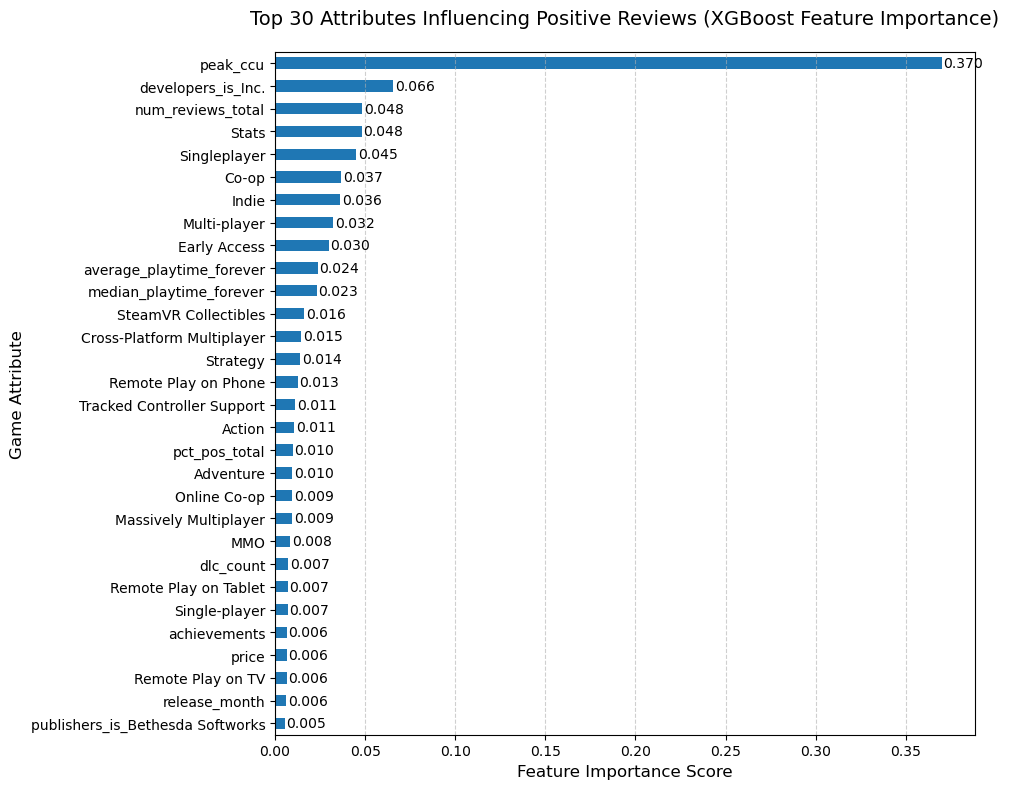

In [24]:
top_features_sorted = final_importance.nlargest(30).sort_values(ascending=True)

plt.figure(figsize=(10, 8))

top_features_sorted.plot(kind='barh', color='#1f77b4')

plt.title('Top 30 Attributes Influencing Positive Reviews (XGBoost Feature Importance)', fontsize=14, pad=20)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Game Attribute', fontsize=12)

for index, value in enumerate(top_features_sorted):
    plt.text(value + 0.001, index, f'{value:.3f}', va='center')

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('feature_importance_bar.png', dpi=300)
plt.show()

In [47]:
top_features_sorted

publishers_is_Bethesda Softworks    0.005308
release_month                       0.006310
Remote Play on TV                   0.006415
price                               0.006454
achievements                        0.006477
Single-player                       0.007012
Remote Play on Tablet               0.007048
dlc_count                           0.007159
MMO                                 0.008413
Massively Multiplayer               0.009341
Online Co-op                        0.009446
Adventure                           0.009656
pct_pos_total                       0.009772
Action                              0.010712
Tracked Controller Support          0.011346
Remote Play on Phone                0.012637
Strategy                            0.013953
Cross-Platform Multiplayer          0.014550
SteamVR Collectibles                0.016034
median_playtime_forever             0.023042
average_playtime_forever            0.023718
Early Access                        0.029736
Multi-play

We will determine which values are positively correlated with positive reviews and which are negative. This is straight forward for the numerical categories.

In [25]:
numerical_correlation = df[['positive', 
                            'peak_ccu', 
                            'num_reviews_total',
                            'median_playtime_forever',
                            'average_playtime_forever', 
                            'dlc_count',
                            'price', 
                            'metacritic_score',
                            'release_year']].corr()['positive'].sort_values(ascending=False)

print(numerical_correlation)

positive                    1.000000
num_reviews_total           0.958685
peak_ccu                    0.873564
average_playtime_forever    0.199399
metacritic_score            0.108317
median_playtime_forever     0.055826
price                       0.031469
dlc_count                   0.018614
release_year               -0.049522
Name: positive, dtype: float64


Then to graph the numeric correlations.

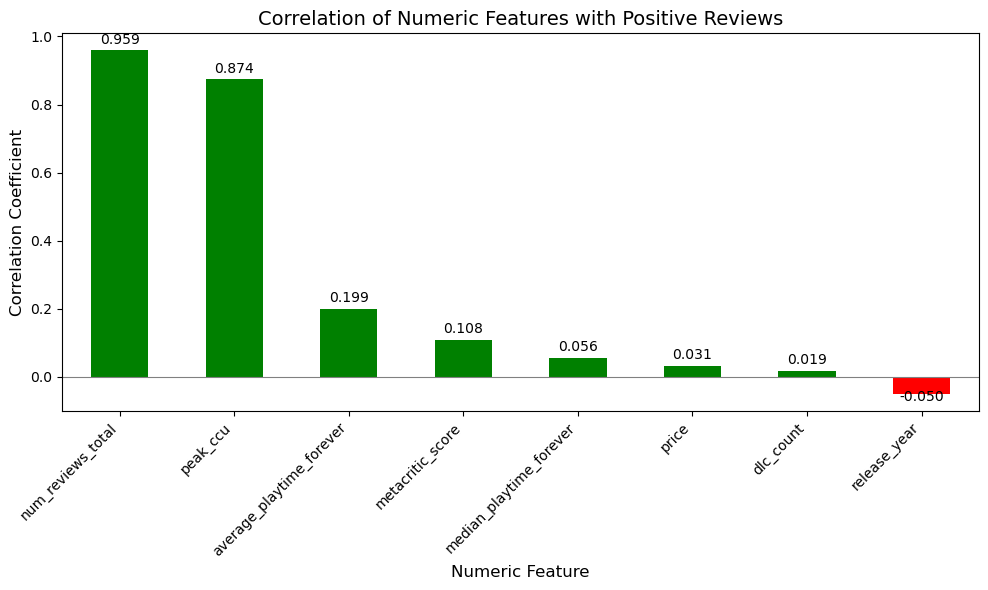

In [26]:
corr_series = numerical_correlation.drop('positive').sort_values(ascending=False)

colors = ['green' if x > 0 else 'red' for x in corr_series]

plt.figure(figsize=(10, 6))

corr_series.plot(kind='bar', color=colors)

plt.title('Correlation of Numeric Features with Positive Reviews', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xlabel('Numeric Feature', fontsize=12)

plt.axhline(0, color='grey', linewidth=0.8)

for i, v in enumerate(corr_series):
    plt.text(i, v + np.sign(v) * 0.02, f'{v:.3f}', color='black', ha='center', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('numeric_correlation_chart.png', dpi=300)
plt.show()

Notice that year was significant in importance for positive reviews according to the previous analysis. It is possible that there are more interesting patterns to be found in release timing. Though, year itself may be important purely because older games have more time to get more positive reviews. To eliminate this factor, we will switch to total percent of positive reviews. We will start by determining which month has the highest average reviews.

In [27]:
monthly_analysis = df.groupby('release_month')['pct_pos_total'].mean().sort_values(ascending=False)

In [28]:
monthly_analysis

release_month
6     47.044103
8     46.630748
10    46.387884
9     46.178507
5     45.608419
4     45.395249
1     45.239192
7     44.986289
3     44.746609
11    44.503236
12    44.126272
2     44.028122
Name: pct_pos_total, dtype: float64

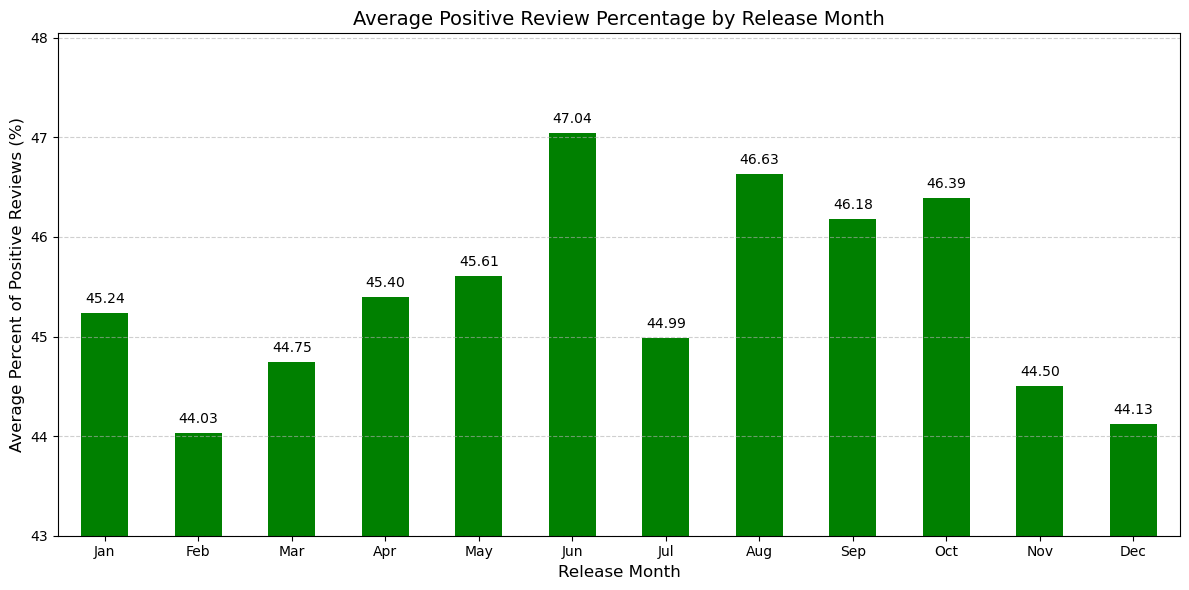

In [29]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_analysis = monthly_analysis.sort_index(ascending=True)
monthly_analysis.index = [month_names[int(i)-1] for i in monthly_analysis.index]

plt.figure(figsize=(12, 6))
monthly_analysis.plot(kind='bar', color='green')

plt.title('Average Positive Review Percentage by Release Month', fontsize=14)
plt.ylabel('Average Percent of Positive Reviews (%)', fontsize=12)
plt.xlabel('Release Month', fontsize=12)
plt.xticks(rotation=0)
plt.ylim(43, monthly_analysis.max() + 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, v in enumerate(monthly_analysis):
    plt.text(i, v + 0.1, f'{v:.2f}', color='black', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('monthly_review_percentage.png', dpi=300)
plt.show()

We will analyze years next, limiting it to 2000 and later.

In [30]:
df_recent = df[df['release_year'] >= 2000].copy()

y_pct = df_recent['pct_pos_total'].values.reshape(-1, 1)

X_year = df_recent['release_year'].values.reshape(-1, 1)

year_model = LinearRegression().fit(X_year, y_pct)

print(f"Coefficient (Trend per Year): {year_model.coef_[0][0]:.4f}")
print(f"R-squared (Year): {year_model.score(X_year, y_pct):.4f}")

Coefficient (Trend per Year): -2.3509
R-squared (Year): 0.0302


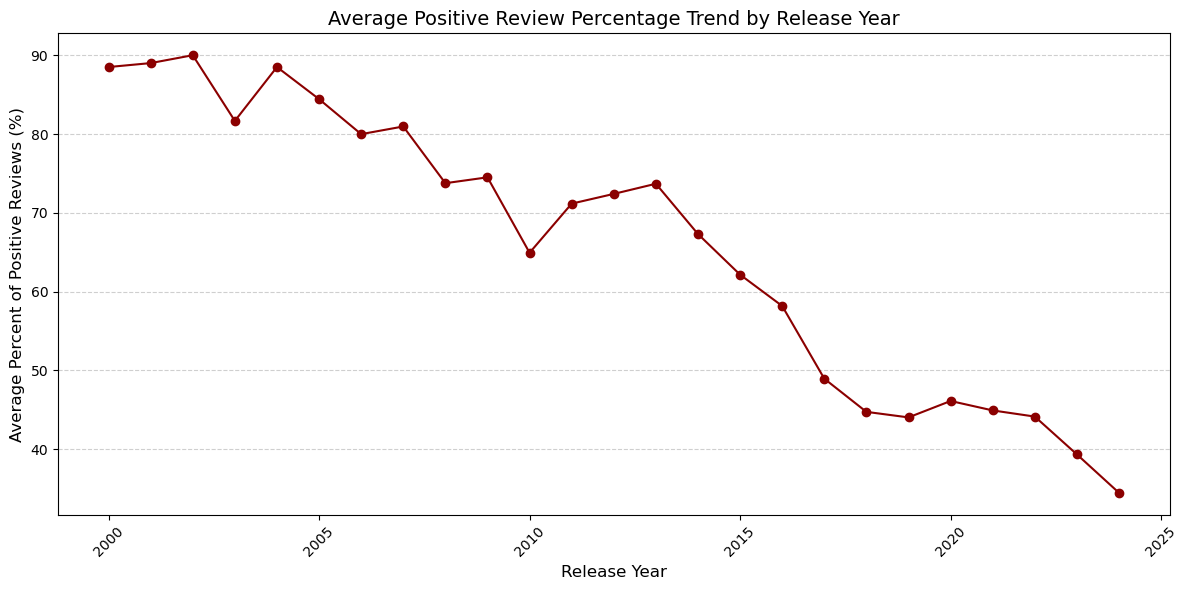

In [31]:
yearly_analysis = df.groupby('release_year')['pct_pos_total'].mean()

yearly_analysis = yearly_analysis[yearly_analysis.index >= 2000]

plt.figure(figsize=(12, 6))

yearly_analysis.plot(kind='line', marker='o', linestyle='-', color='darkred')

plt.title('Average Positive Review Percentage Trend by Release Year', fontsize=14)
plt.ylabel('Average Percent of Positive Reviews (%)', fontsize=12)
plt.xlabel('Release Year', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('yearly_review_percentage_trend.png', dpi=300)
plt.show()

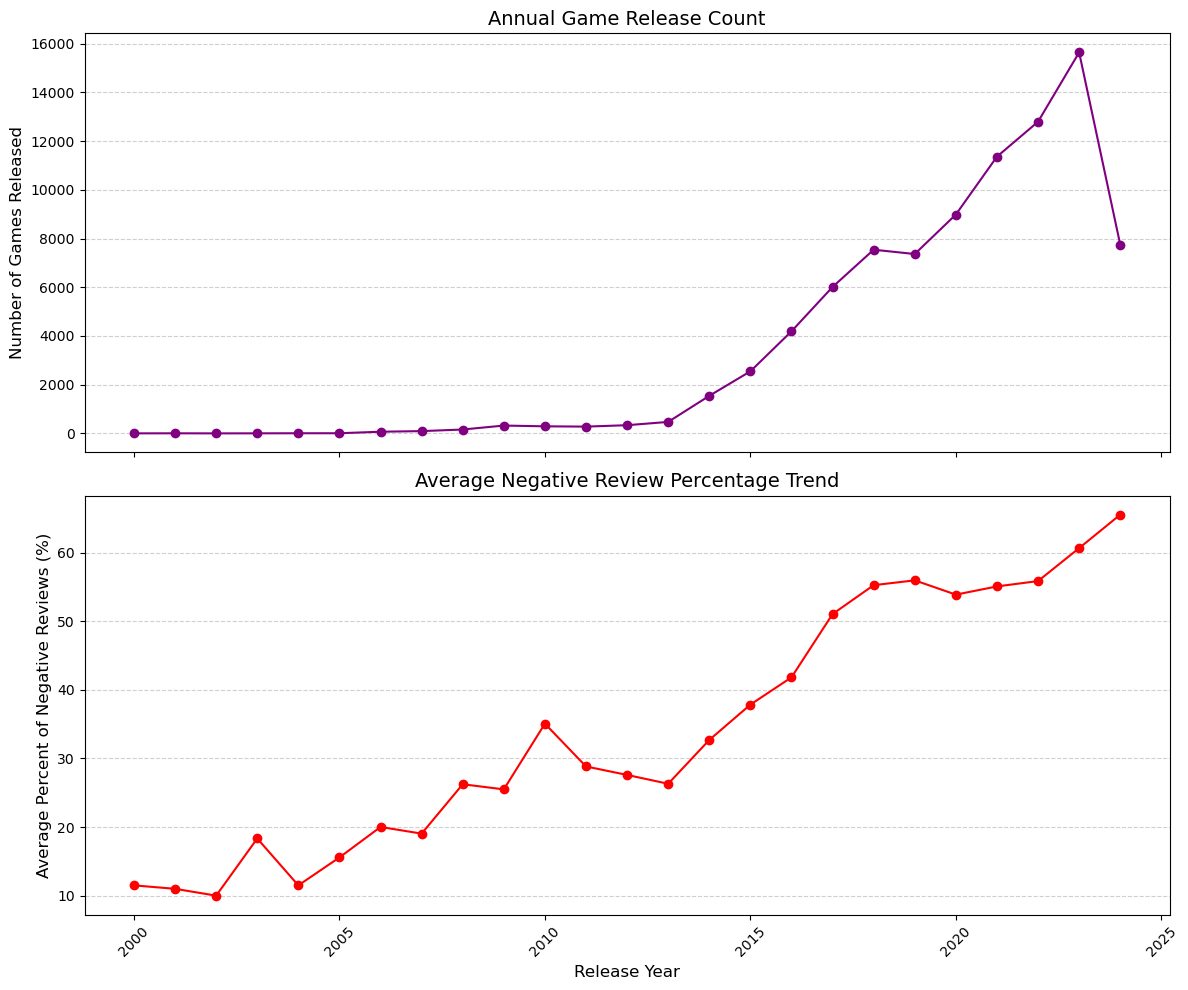

In [32]:
df_long_term = df[df['release_year'] >= 2000].copy()

game_count_yearly = df_long_term.groupby('release_year').size()

yearly_positive_pct = df_long_term.groupby('release_year')['pct_pos_total'].mean()
yearly_negative_pct = 100 - yearly_positive_pct

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

axes[0].plot(game_count_yearly.index, game_count_yearly.values, marker='o', color='purple')
axes[0].set_title('Annual Game Release Count', fontsize=14)
axes[0].set_ylabel('Number of Games Released', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

axes[1].plot(yearly_negative_pct.index, yearly_negative_pct.values, marker='o', color='red')
axes[1].set_title('Average Negative Review Percentage Trend', fontsize=14)
axes[1].set_ylabel('Average Percent of Negative Reviews (%)', fontsize=12)
axes[1].set_xlabel('Release Year', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('annual_trend_comparison.png', dpi=300)
plt.show()

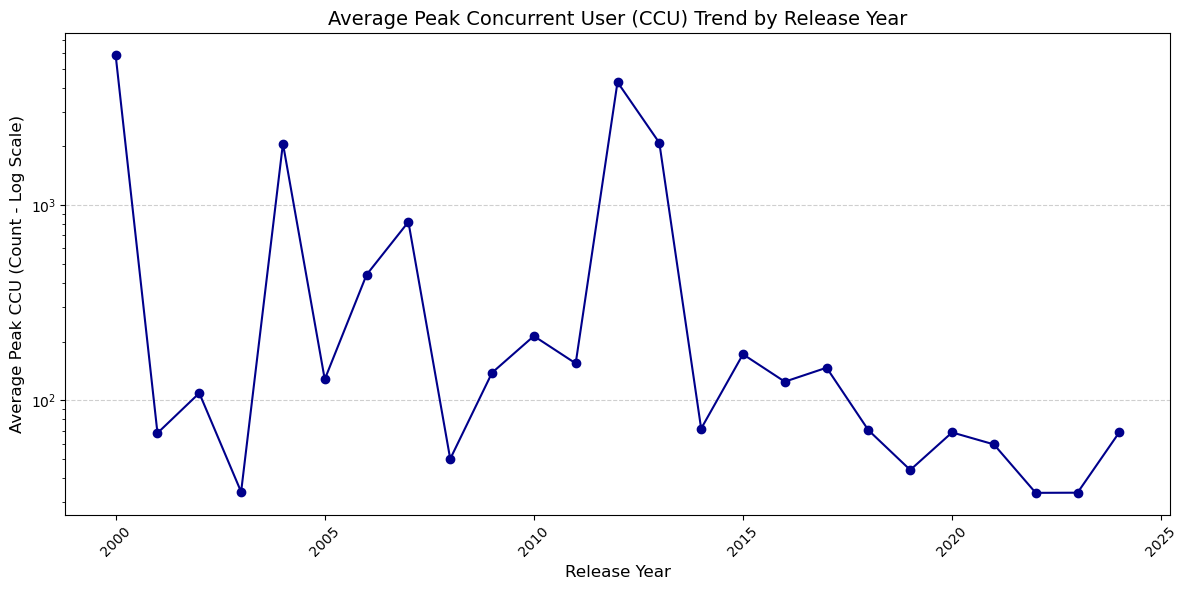

In [33]:
df_long_term = df[df['release_year'] >= 2000].copy()

yearly_avg_ccu = df_long_term.groupby('release_year')['peak_ccu'].mean()

plt.figure(figsize=(12, 6))

yearly_avg_ccu.plot(kind='line', marker='o', linestyle='-', color='darkblue')

plt.title('Average Peak Concurrent User (CCU) Trend by Release Year', fontsize=14)
plt.ylabel('Average Peak CCU (Count - Log Scale)', fontsize=12)
plt.xlabel('Release Year', fontsize=12)
plt.xticks(rotation=45)
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('annual_avg_peak_ccu_trend.png', dpi=300)
plt.show()

In [34]:
yearly_avg_ccu

release_year
2000    5855.500000
2001      68.000000
2002     109.000000
2003      34.000000
2004    2067.500000
2005     128.142857
2006     439.898551
2007     820.468085
2008      50.137500
2009     138.552795
2010     213.580756
2011     154.731183
2012    4263.228487
2013    2084.584746
2014      71.665587
2015     172.259710
2016     124.678912
2017     147.012970
2018      70.336603
2019      44.026066
2020      68.544787
2021      59.519799
2022      33.617362
2023      33.674294
2024      68.723039
Name: peak_ccu, dtype: float64

In [35]:
df_original = pd.read_csv('games_may2024_full.csv')

df_clean = df_original[['name', 'release_date', 'peak_ccu']].copy()

df_clean['release_year'] = pd.to_datetime(df_clean['release_date'], errors='coerce').dt.year.fillna(0).astype(int)

df_clean = df_clean[(df_clean['release_year'] >= 2000) & (df_clean['peak_ccu'] > 0)]

idx = df_clean.groupby(['release_year'])['peak_ccu'].transform(max) == df_clean['peak_ccu']

top_ccu_games = df_clean[idx].sort_values(by='release_year')

top_ccu_games = top_ccu_games.drop_duplicates(subset=['release_year'], keep='first')

top_ccu_games = top_ccu_games[['release_year', 'name', 'peak_ccu']]

print("Peak CCU Game Identified Per Release Year")
print(top_ccu_games.to_markdown(index=False))

Peak CCU Game Identified Per Release Year
|   release_year | name                             |   peak_ccu |
|---------------:|:---------------------------------|-----------:|
|           2000 | Counter-Strike                   |      11703 |
|           2001 | Gothic 1                         |        198 |
|           2002 | Mafia                            |        109 |
|           2003 | Day of Defeat                    |        101 |
|           2004 | Counter-Strike: Source           |      10889 |
|           2005 | Gothic II: Gold Edition          |        739 |
|           2006 | Garry's Mod                      |      21459 |
|           2007 | Team Fortress 2                  |      70485 |
|           2008 | SPORE™                           |        928 |
|           2009 | Left 4 Dead 2                    |      22505 |
|           2010 | Fallout: New Vegas               |      26435 |
|           2011 | Terraria                         |      23331 |
|           2012 | C

/var/folders/lg/d5y0qdy57yn70blc7yr5rcwc0000gn/T/ipykernel_25703/2200474350.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = df_clean.groupby(['release_year'])['peak_ccu'].transform(max) == df_clean['peak_ccu']


The peak CCU data collected is flawed and should not be trusted too closely, at least with recent years. Baldur's Gate 3 is among the top 10 highest CCU games in history, and it exceeded the reported peak for 2023. The actual top game in 2023 would have been Hogwarts Legacy. If we check Baldur's Gate 3, it has a peak CCU collected substantially lower than the actual number. It seems that later year games have inaccurate peak CCU data.

In [36]:
file_name = 'games_may2024_full.csv'

try:
    df_original = pd.read_csv(file_name)
except FileNotFoundError:
    print(f"Error: File not found. Please ensure '{file_name}' is accessible.")
    raise

bg3_data = df_original[
    df_original['name'].str.contains('Baldur\'s Gate 3', case=False, na=False)
].copy()

bg3_data['release_year'] = pd.to_datetime(bg3_data['release_date'], errors='coerce').dt.year.fillna(0).astype(int)

key_columns = ['AppID', 'name', 'release_date', 'release_year', 'peak_ccu', 'positive', 'negative']
bg3_data = bg3_data[key_columns].sort_values(by='peak_ccu', ascending=False)

print(bg3_data.to_markdown(index=False))

|   AppID | name            | release_date   |   release_year |   peak_ccu |   positive |   negative |
|--------:|:----------------|:---------------|---------------:|-----------:|-----------:|-----------:|
| 1086940 | Baldur's Gate 3 | 2023-08-03     |           2023 |      64729 |     588423 |      19560 |


We will see if we can determine any interesting clusters using K-Means. We will prepare the data.

In [37]:
X_cleaned = X.dropna()

y_cleaned = y_scaled[X_cleaned.index]

In [38]:
scaler_kmeans = StandardScaler()
X_scaled = scaler_kmeans.fit_transform(X_cleaned)

X_scaled_df = pd.DataFrame(X_scaled, columns=X_cleaned.columns, index=X_cleaned.index)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


We will focus on components that account for the most variance.

In [39]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled_df)

print(f"Reduced features from {X_scaled_df.shape[1]} to {pca.n_components_} components.")

sample_size = 10000 
sample_indices = np.random.choice(X_pca.shape[0], size=sample_size, replace=False)
X_sample = X_pca[sample_indices]

Reduced features from 691 to 10 components.


Silhouette scores will review the optimal k value.

k=2: Silhouette Score = 0.4383
k=3: Silhouette Score = 0.4272
k=4: Silhouette Score = 0.4441
k=5: Silhouette Score = 0.4369
k=6: Silhouette Score = 0.4352
k=7: Silhouette Score = 0.4504
k=8: Silhouette Score = 0.4610
k=9: Silhouette Score = 0.4453
k=10: Silhouette Score = 0.2936


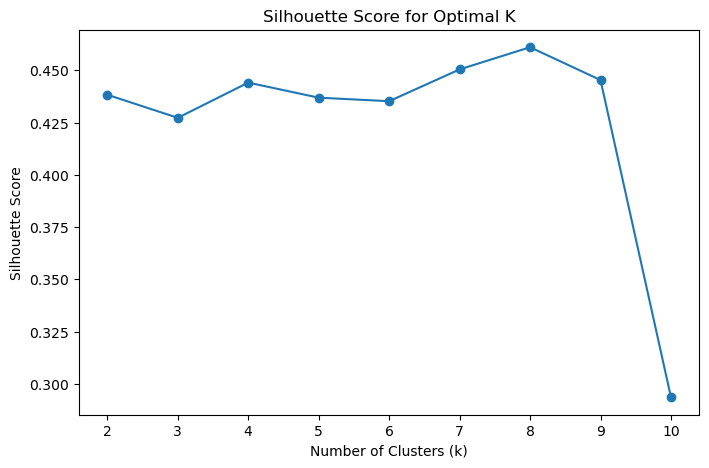

In [40]:
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_pca) 
    
    score = silhouette_score(X_sample, kmeans.labels_[sample_indices])
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")

optimal_k_index = np.argmax(silhouette_scores)
optimal_k = K_range[optimal_k_index]

plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

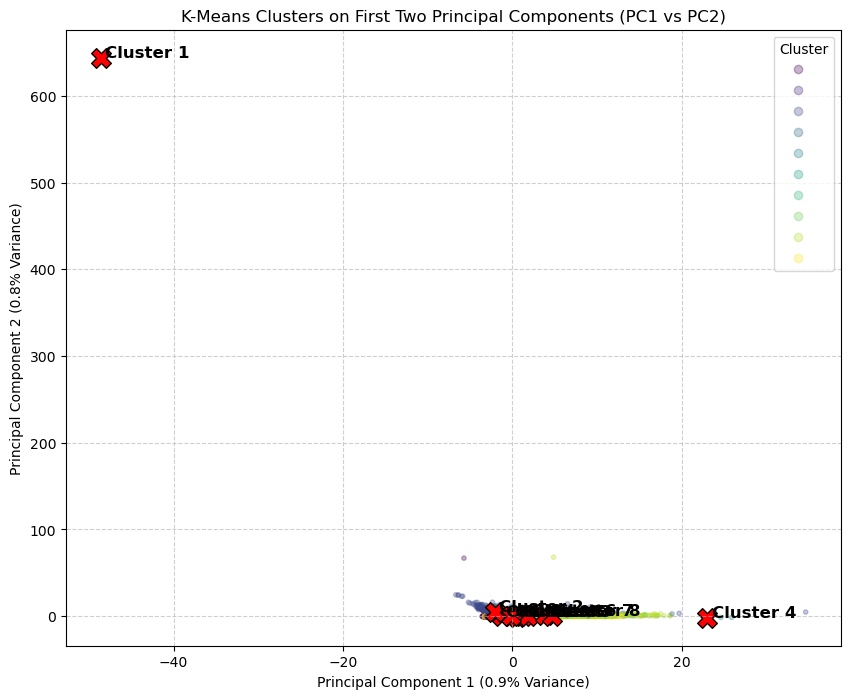

In [41]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_pca[:, 0], # PC1
    X_pca[:, 1], # PC2
    c=kmeans.labels_,
    cmap='viridis',
    s=10,
    alpha=0.3
)

centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker='X',
    s=200,
    c='red',
    edgecolors='black',
    label='Centroids'
)

for i, center in enumerate(centroids):
    plt.text(center[0] + 0.5, center[1], f'Cluster {i}', fontsize=12, weight='bold')

plt.title('K-Means Clusters on First Two Principal Components (PC1 vs PC2)')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)')
plt.legend(handles=scatter.legend_elements()[0], title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('clusters_scatter.png', dpi=300)
plt.show()

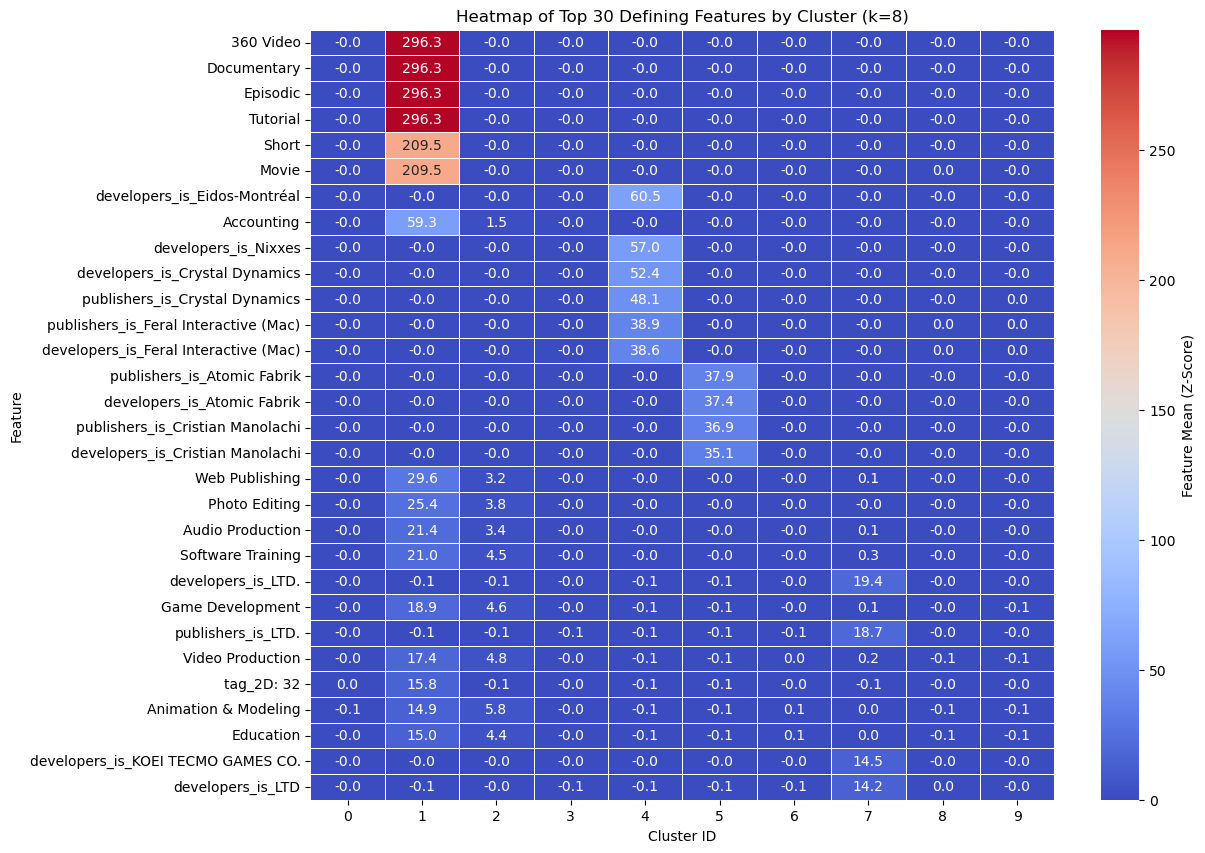

In [45]:
X_scaled_df['Cluster'] = kmeans.labels_

scaled_centroids_df = X_scaled_df.groupby('Cluster').mean()

X_scaled_df = X_scaled_df.drop('Cluster', axis=1)
top_variable_features = scaled_centroids_df.std().nlargest(30).index

heatmap_data = scaled_centroids_df[top_variable_features]

plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_data.T,
    cmap='coolwarm',
    annot=True,
    fmt=".1f",
    linewidths=.5,
    cbar_kws={'label': 'Feature Mean (Z-Score)'}
)

plt.title('Heatmap of Top 30 Defining Features by Cluster (k=8)')
plt.xlabel('Cluster ID')
plt.ylabel('Feature')
plt.savefig('cluster_heatmap.png', dpi=300)
plt.show()

This K-Means analysis fails and is driven by noise and zero value features, resulting in about 1.7% variance accounted for which shows that the model is not good. What we can attempt is to take the top features identified by the previous regression and attempt K-Means soley on those to eliminate noise.

In [48]:
top_30_features = [
    'peak_ccu', 'developers_is_Inc.', 'num_reviews_total', 'Stats', 'Singleplayer', 
    'Co-op', 'Indie', 'Multi-player', 'Early Access', 'average_playtime_forever', 
    'median_playtime_forever', 'Cross-Platform Multiplayer', 'Strategy', 
    'Remote Play on Phone', 'Tracked Controller Support', 'Action', 'pct_pos_total', 
    'Adventure', 'Online Co-op', 'Massively Multiplayer', 'MMO', 'dlc_count', 
    'Remote Play on Tablet', 'Single-player', 'achievements', 'price', 
    'Remote Play on TV', 'release_month', 'publishers_is_Bethesda Softworks', 
    'SteamVR Collectibles'
]

final_feature_set = [col for col in top_30_features if col in df.columns]

X_optimal = df[final_feature_set].copy()
X_optimal = X_optimal.dropna()

scaler_optimal = StandardScaler()
X_scaled_optimal = scaler_optimal.fit_transform(X_optimal)

sample_size = 10000 
sample_indices = np.random.choice(X_scaled_optimal.shape[0], size=sample_size, replace=False)
X_sample = X_scaled_optimal[sample_indices] 

silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_scaled_optimal) 
    
    score = silhouette_score(X_sample, kmeans.labels_[sample_indices])
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")

optimal_k_index = np.argmax(silhouette_scores)
optimal_k = K_range[optimal_k_index]

print(f"\nOptimal k: {optimal_k} (Score: {silhouette_scores[optimal_k_index]:.4f})")

Clustering on 29 validated features.


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


k=2: Silhouette Score = 0.4233
k=3: Silhouette Score = 0.4191
k=4: Silhouette Score = 0.4138
k=5: Silhouette Score = 0.0964
k=6: Silhouette Score = 0.1228
k=7: Silhouette Score = 0.1338
k=8: Silhouette Score = 0.1019
k=9: Silhouette Score = 0.1351
k=10: Silhouette Score = 0.1365

Optimal k identified: 2 (Score: 0.4233)


In [53]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
kmeans.fit(X_scaled_optimal)

X_optimal['Cluster'] = kmeans.labels_

final_centroids_df = X_optimal.groupby('Cluster').mean()

diff = abs(final_centroids_df.loc[0] - final_centroids_df.loc[1]).sort_values(ascending=False)

top_30_diff_features = diff.head(30).index.tolist()

defining_centroids_df = final_centroids_df[top_30_diff_features]

cluster_sizes = X_optimal['Cluster'].value_counts().sort_index()
print(cluster_sizes.to_markdown(numalign="left", stralign="left"))

| Cluster   | count   |
|:----------|:--------|
| 0         | 10193   |
| 1         | 77613   |


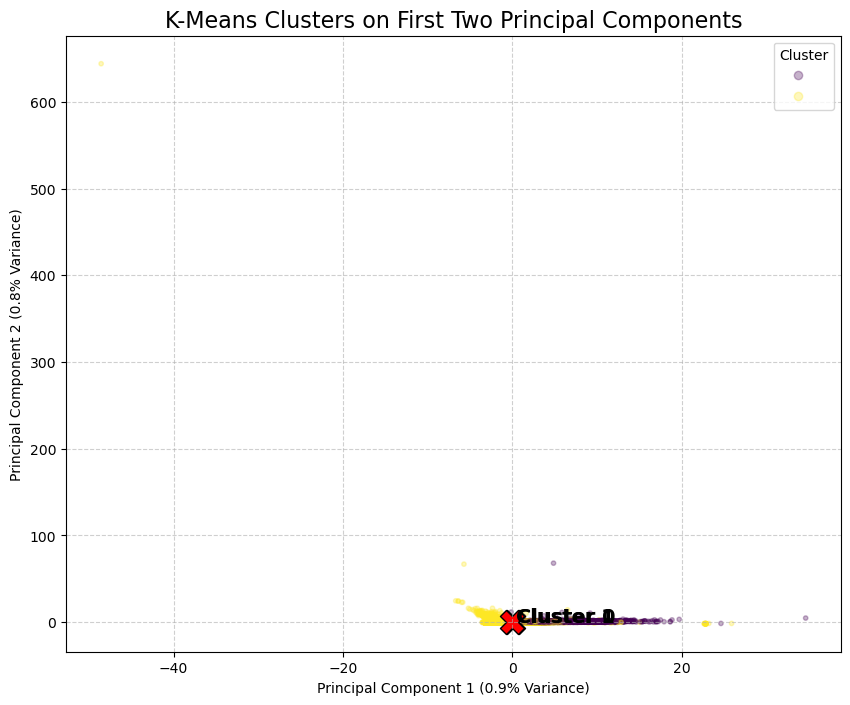

In [54]:
variance_ratio_pc1 = pca.explained_variance_ratio_[0] * 100
variance_ratio_pc2 = pca.explained_variance_ratio_[1] * 100

centroids = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=kmeans.labels_,
    cmap='viridis',
    s=10, 
    alpha=0.3
)

plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker='X',
    s=300, 
    c='red',
    edgecolors='black',
    label='Centroids'
)

for i, center in enumerate(centroids):
    plt.text(center[0] + 0.5, center[1], f'Cluster {i}', fontsize=14, weight='bold')

plt.title('K-Means Clusters on First Two Principal Components', fontsize=16)
plt.xlabel(f'Principal Component 1 ({variance_ratio_pc1:.1f}% Variance)')
plt.ylabel(f'Principal Component 2 ({variance_ratio_pc2:.1f}% Variance)')

plt.legend(handles=scatter.legend_elements()[0], title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('clusters_full_scale_voronoi.png', dpi=300)
plt.show()

The outcome is almost identical to when we included all the OHE data and did k=8. We will examine the heatmap to see what is driving this structure.

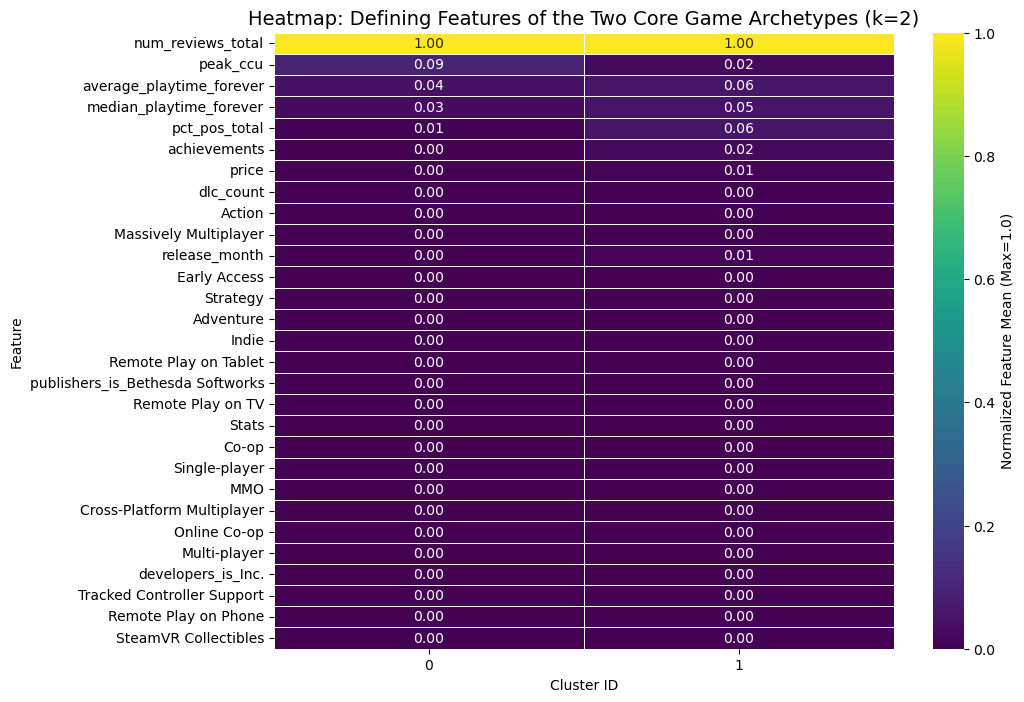

In [55]:
diff = abs(final_centroids_df.loc[0] - final_centroids_df.loc[1]).sort_values(ascending=False)
top_30_diff_features = diff.head(30).index.tolist()

heatmap_data = final_centroids_df[top_30_diff_features]

heatmap_data_normalized = heatmap_data.div(heatmap_data.max(axis=1), axis=0).fillna(0)

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data_normalized.T,
    cmap='viridis',
    annot=True,
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Normalized Feature Mean (Max=1.0)'}
)

plt.title('Heatmap: Clusters (k=2)', fontsize=14)
plt.xlabel('Cluster ID')
plt.ylabel('Feature')
plt.savefig('k2_heatmap.png', dpi=300)
plt.show()

Number of total reviews skews the heatmap and the value is equally important for both. We will drop it and make a better heatmap.

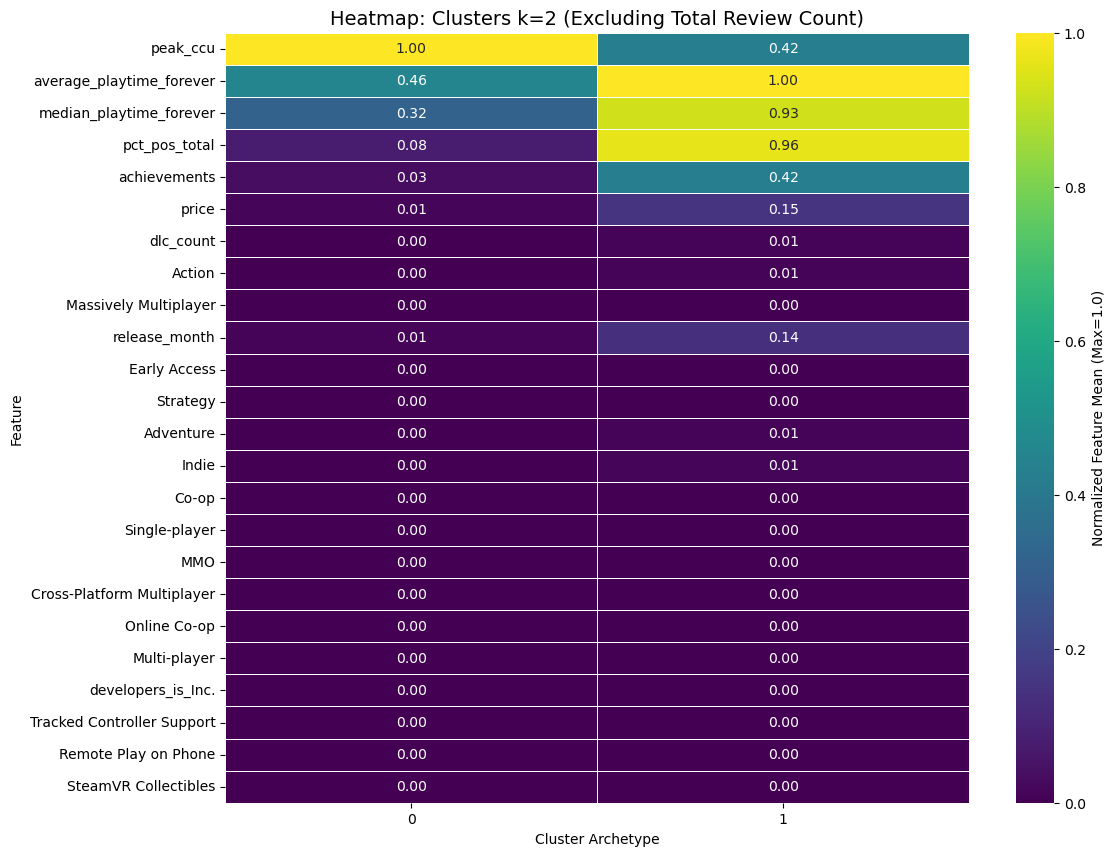

In [59]:
all_features_excluding_reviews = [
    'peak_ccu', 'average_playtime_forever', 'median_playtime_forever', 
    'pct_pos_total', 'achievements', 'price', 'dlc_count', 
    'Action', 'Massively Multiplayer', 'release_month', 'Early Access', 
    'Strategy', 'Adventure', 'Indie', 'Co-op', 'Single-player', 
    'MMO', 'Cross-Platform Multiplayer', 'Online Co-op', 'Multi-player', 
    'developers_is_Inc.', 'Tracked Controller Support', 'Remote Play on Phone', 
    'SteamVR Collectibles'
]
features_for_heatmap = [col for col in all_features_excluding_reviews if col in final_centroids_df.columns]

heatmap_data_raw = final_centroids_df[features_for_heatmap]

heatmap_data_normalized = heatmap_data_raw.div(heatmap_data_raw.max(axis=1), axis=0).fillna(0)

plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_data_normalized.T,
    cmap='viridis',
    annot=True,
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Normalized Feature Mean (Max=1.0)'}
)

plt.title('Heatmap: Clusters k=2 (Excluding Total Review Count)', fontsize=14)
plt.xlabel('Cluster Archetype')
plt.ylabel('Feature')
plt.savefig('heatmapk2_nototrev.png', dpi=300)
plt.show()

The heatmap reveals two clusters: the blockbuster games that get huge initial CCUs but taper off over time and the games that might not be blockbusters initially but have a sustained core of happy users over time which also goes along with percentage or positive reviews. However, we also still have very low variance accounted for by this model. We will test its accuracy.

In [66]:
review_threshold = df['num_reviews_total'].quantile(0.90)
y_target = (df['num_reviews_total'] > review_threshold).astype(int)

X_final = pd.DataFrame(X_scaled_optimal, index=X_optimal.index)
y_final = y_target.loc[X_final.index]

X_final['Cluster_ID'] = X_optimal['Cluster'] 

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42
)
knn = KNeighborsClassifier(n_neighbors=7) 

X_train_base = X_train.drop('Cluster_ID', axis=1) 
X_test_base = X_test.drop('Cluster_ID', axis=1) 

knn.fit(X_train_base, y_train)
pred = knn.predict(X_test_base)
accuracy = accuracy_score(y_test, pred)

accuracy

0.9197130167406902

In [65]:
param_grid = {'n_neighbors': np.arange(1, 31, 2)} 

knn_model = KNeighborsClassifier()
grid_search = GridSearchCV(
    knn_model, 
    param_grid, 
    cv=5,
    scoring='accuracy'
)

grid_search.fit(X_train_base, y_train)

best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_ 

print(f"Optimal k for kNN: {best_k}")
print(f"Mean Cross-Validation Accuracy (at k={best_k}): {best_score:.4f}")

Optimal k for kNN: 7
Mean Cross-Validation Accuracy (at k=7): 0.9189


Despite the issues with lack of variance accounted for, the model has been assessed to be 91% accurate, which is considered a solid score.